In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import plotly.express as px
import plotly.graph_objects as go
import scipy
import re
import requests
from time import sleep
from bs4 import BeautifulSoup

## EDA: Washington Post Dataset

Data is taken from https://github.com/washingtonpost/data-police-shootings

See accompanying Washington Post article here: https://www.washingtonpost.com/graphics/investigations/police-shootings-database/

Each row has the following variables:

`id`: a unique identifier for each victim

`name`: the name of the victim

`date`: the date of the fatal shooting in YYYY-MM-DD format

`manner_of_death`:
* shot
* shot and Tasered

`armed`: indicates that the victim was armed with some sort of implement that a police officer believed could inflict harm
* undetermined: it is not known whether or not the victim had a weapon
* unknown: the victim was armed, but it is not known what the object was
* unarmed: the victim was not armed

`age`: the age of the victim

`gender`: the gender of the victim. The Post identifies victims by the gender they identify with if reports indicate that it differs from their biological sex.
* M: Male
* F: Female
* None: unknown

`race`:
* W: White, non-Hispanic
* B: Black, non-Hispanic
* A: Asian
* N: Native American
* H: Hispanic
* O: Other
* None: unknown

`city`: the municipality where the fatal shooting took place. Note that in some cases this field may contain a county name if a more specific municipality is unavailable or unknown.

`state`: two-letter postal code abbreviation

`signs of mental illness`: News reports have indicated the victim had a history of mental health issues, expressed suicidal intentions or was experiencing mental distress at the time of the shooting.

`threat_level`: The threat_level column was used to flag incidents for the story by Amy Brittain in October 2015. http://www.washingtonpost.com/sf/investigative/2015/10/24/on-duty-under-fire/ As described in the story, the general criteria for the attack label was that there was the most direct and immediate threat to life. That would include incidents where officers or others were shot at, threatened with a gun, attacked with other weapons or physical force, etc. The attack category is meant to flag the highest level of threat. The other and undetermined categories represent all remaining cases. Other includes many incidents where officers or others faced significant threats.

`flee`: News reports have indicated the victim was moving away from officers
* Foot
* Car
* Not fleeing
The threat column and the fleeing column are not necessarily related. For example, there is an incident in which the suspect is fleeing and at the same time turns to fire at gun at the officer. Also, attacks represent a status immediately before fatal shots by police while fleeing could begin slightly earlier and involve a chase.

`body_camera`: News reports have indicated an officer was wearing a body camera and it may have recorded some portion of the incident.

`latitude` and `longitude`: the location of the shooting expressed as WGS84 coordinates, geocoded from addresses. The coordinates are rounded to 3 decimal places, meaning they have a precision of about 80-100 meters within the contiguous U.S.

`is_geocoding_exact`: reflects the accuracy of the coordinates. true means that the coordinates are for the location of the shooting (within approximately 100 meters), while false means that coordinates are for the centroid of a larger region, such as the city or county where the shooting happened.

In [2]:
df = pd.read_csv('data/fatal-police-shootings-data.csv')
df.head()

id                name        date   manner_of_death       armed   age  \
0   3          Tim Elliot  2015-01-02              shot         gun  53.0   
1   4    Lewis Lee Lembke  2015-01-02              shot         gun  47.0   
2   5  John Paul Quintero  2015-01-03  shot and Tasered     unarmed  23.0   
3   8     Matthew Hoffman  2015-01-04              shot  toy weapon  32.0   
4   9   Michael Rodriguez  2015-01-04              shot    nail gun  39.0   

  gender race           city state  signs_of_mental_illness threat_level  \
0      M    A        Shelton    WA                     True       attack   
1      M    W          Aloha    OR                    False       attack   
2      M    H        Wichita    KS                    False        other   
3      M    W  San Francisco    CA                     True       attack   
4      M    H          Evans    CO                    False       attack   

          flee  body_camera  longitude  latitude  is_geocoding_exact  
0  Not fleeing        False   -123.122    47.247                True  
1  Not fleeing        False   -122.892    45.487                True  
2  Not fleeing        False    -97.281    37.695                True  
3  Not fleeing        False   -122.422    37.763                True  
4  Not fleeing        False   -104.692    40.384                True

In [3]:
# Convert the date to datetime:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
df = df.dropna()

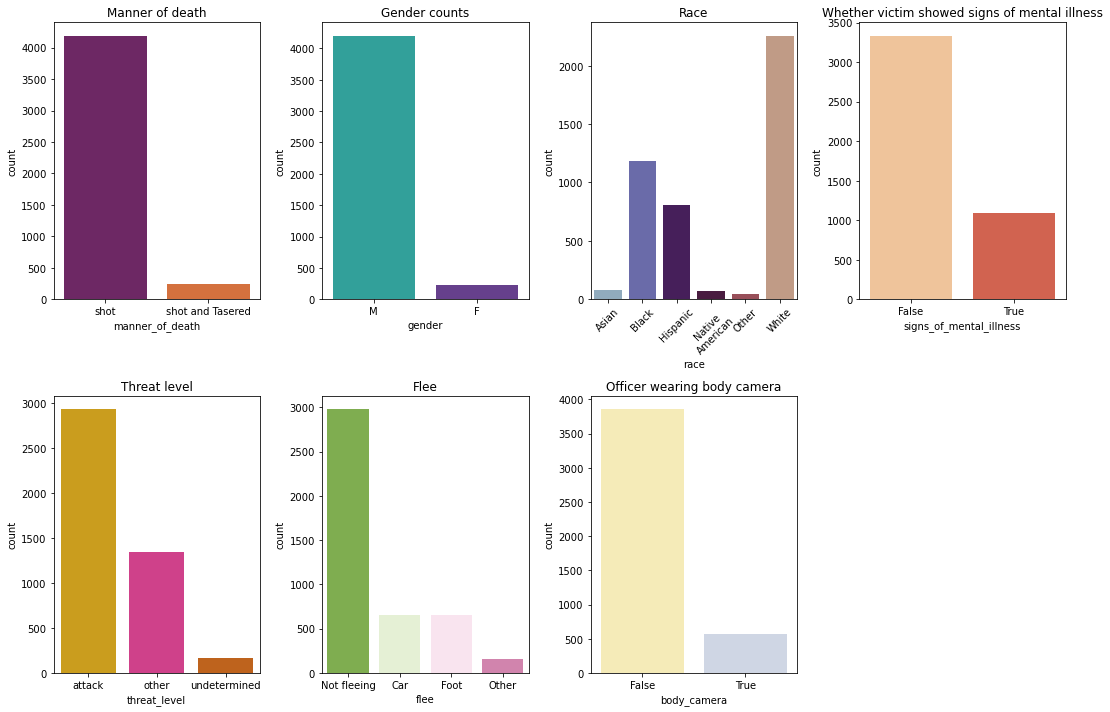

In [4]:
# Plotting based on columns:
# Manner of death, gender, race, mental illness, threat level, flee, body camera:

fig, ax = plt.subplots(2,4, figsize=(15,10))
ax = ax.flatten()

# Manner of death:
sns.countplot(data=df, x='manner_of_death', ax=ax[0], palette='inferno')
ax[0].set_title('Manner of death')

# Gender:
sns.countplot(data=df, x='gender', ax=ax[1], palette=['lightseagreen', 'rebeccapurple'])
ax[1].set_title('Gender counts')

# Race:
sns.countplot(data=df, x=df['race'].sort_values(ascending=True), ax=ax[2], palette='twilight')
races = ['Asian', 'Black', 'Hispanic', 'Native\nAmerican', 'Other', 'White']
ax[2].set_title('Race')
ax[2].set_xticklabels(labels=races, rotation=45)

# Signs of mental illness:
sns.countplot(data=df, x='signs_of_mental_illness', ax=ax[3], palette='OrRd')
ax[3].set_title('Whether victim showed signs of mental illness')

# Threat level:
sns.countplot(data=df, x='threat_level', ax=ax[4], palette='Dark2_r')
ax[4].set_title('Threat level')

# Flee:
sns.countplot(data=df, x='flee', ax=ax[5], palette='PiYG_r')
ax[5].set_title('Flee')

# Body camera:
sns.countplot(data=df, x='body_camera', ax=ax[6], palette='Pastel2_r')
ax[6].set_title('Officer wearing body camera')

ax[7].set_axis_off()

plt.tight_layout()
plt.show()

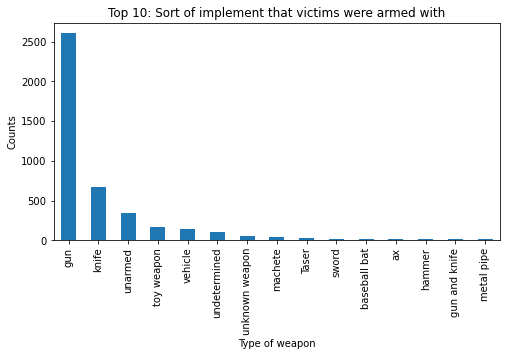

In [5]:
# Armed:
fig, ax = plt.subplots(figsize=(8,4))
df['armed'].value_counts()[:15].plot(kind='bar')
ax.set_xlabel('Type of weapon')
ax.set_ylabel('Counts')
ax.set_title('Top 10: Sort of implement that victims were armed with')
# sns.countplot(df['armed'], ax=ax)
# ax.set_title('Victim armed with:')
plt.show()

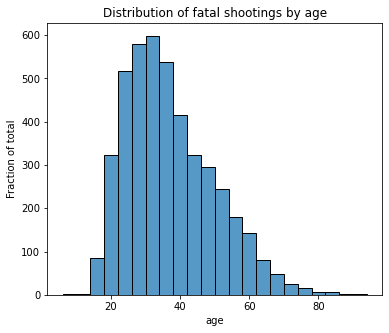

In [6]:
# Age distribution:
fig, ax = plt.subplots(figsize=(6,5))
sns.histplot(df['age'], ax=ax, kde=False, binwidth=4)
ax.set_ylabel('Fraction of total')
ax.set_title('Distribution of fatal shootings by age')
plt.show()

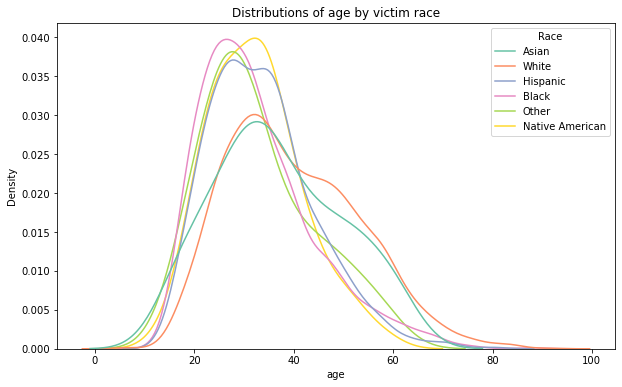

In [7]:
# Plot distribution of age for each race:
races = df.race.unique()
races = [x for x in races if str(x) != 'nan']
# print(races)

fig, ax = plt.subplots(figsize=(10,6))
g = sns.kdeplot(data=df, x='age', hue='race', ax=ax, fill=False, common_norm=False,
            palette='Set2') # crest
ax.set_title('Distributions of age by victim race')

# Get the colors back, just in case:
colors = []
for col in np.arange(0, len(races)):
    colors.append(ax.get_lines()[col].get_c())

legend = ax.legend_
legend.set_title('Race')
for t, l in zip(legend.texts,('Asian', 'White', 'Hispanic', 'Black', 'Other', 'Native American')):
    t.set_text(l)
    
plt.show()

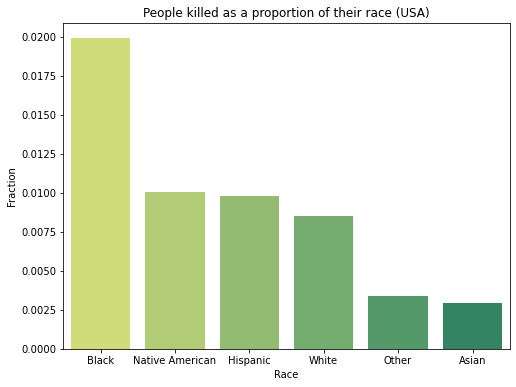

In [8]:
# Get census data and do calculations:
# https://www.census.gov/quickfacts/fact/table/US/PST045219
# Values below are for 2019

# census_dict = {'A': 5.9,  # Asian
#                'W': 60.1, # White
#                'H': 18.5, # Hispanic or Latino
#                'B': 13.4, # Black or African American
#                'O': 2.8,  # Other (two or more races)
#                'N': 1.5   # Native American & Other Pacific Islander,
#                           # American Indian & Alaska Native 
#               } 

# census_df = pd.DataFrame.from_dict(census_dict, orient='index')
# census_df.columns = ['pop_perc']
# census_df.head()

race_list = ['White', 'Black', 'Hispanic', 'Asian', 'Native American', 'Other']

census_series = pd.Series([60.1, 13.4, 18.5, 5.9, 1.5, 2.8], index=race_list)
race_counts = df.race.value_counts(normalize=True)
race_counts.index = race_list
perc_by_race = race_counts / census_series
perc_by_race = perc_by_race.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=perc_by_race.index, y=perc_by_race.values, palette='summer_r')
ax.set_xlabel('Race')
ax.set_ylabel('Fraction')
ax.set_title('People killed as a proportion of their race (USA)')
plt.show()

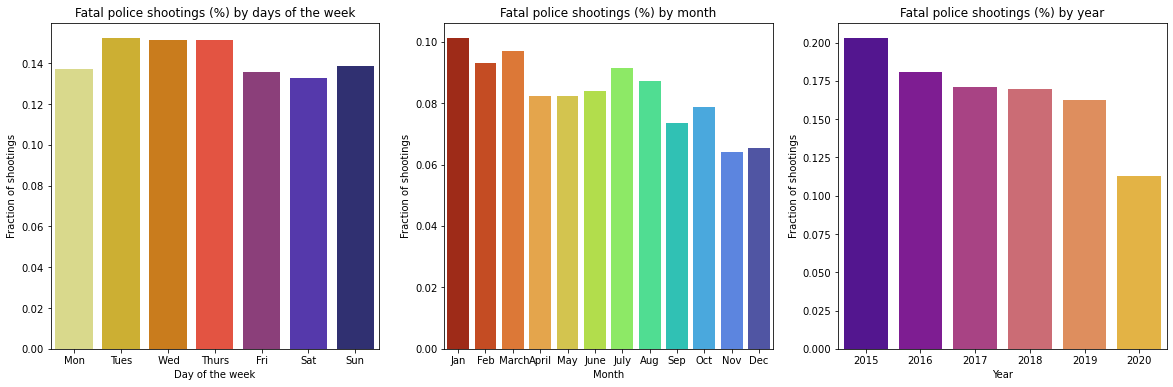

In [9]:
# Get fraction of shootings by day of the week or month
counts = df['date'].apply(lambda x: x.dayofweek).value_counts(normalize=True).sort_index()
counts.index = ['Mon', 'Tues',' Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))
sns.barplot(x=counts.index, y=counts.values, ax=ax1, palette='CMRmap_r')
ax1.set_xlabel('Day of the week')
ax1.set_ylabel('Fraction of shootings')
ax1.set_title('Fatal police shootings (%) by days of the week');

# Get fraction of shootings by day of the week
counts = df['date'].apply(lambda x: x.month).value_counts(normalize=True).sort_index()
counts.index = ['Jan', 'Feb',' March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.barplot(x=counts.index, y=counts.values, ax=ax2, palette='turbo_r')
ax2.set_xlabel('Month')
ax2.set_ylabel('Fraction of shootings')
ax2.set_title('Fatal police shootings (%) by month');

# Get fraction of shootings by year
counts = df['date'].apply(lambda x: x.year).value_counts(normalize=True).sort_index()
sns.barplot(x=counts.index, y=counts.values, ax=ax3, palette='plasma')
ax3.set_xlabel('Year')
ax3.set_ylabel('Fraction of shootings')
ax3.set_title('Fatal police shootings (%) by year');

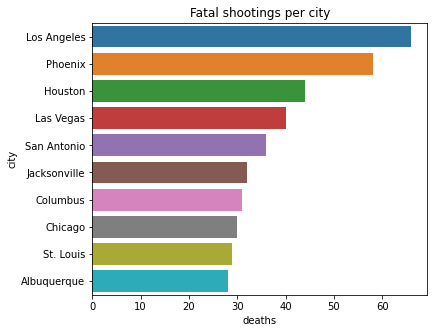

In [10]:
# Group shootings by city

deaths_per_city = df.groupby('city').agg({'city':'count', 'state':'min'})
deaths_per_city.columns = ['deaths', 'state']
deaths_per_city = deaths_per_city.reset_index()
# print(deaths_per_city.head())
# deaths_per_city.head()

deaths_sorted = deaths_per_city.sort_values(by='deaths', ascending=False)
# print(deaths_sorted)

fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(data=deaths_sorted[:10], x='deaths', y='city', ax=ax)
ax.set_title('Fatal shootings per city')
plt.show()

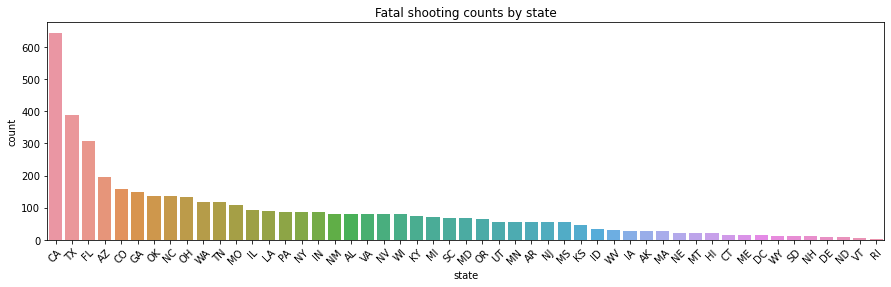

In [11]:
# Plotting deaths by states:
fig, ax = plt.subplots(figsize=(15,4))
order = df['state'].value_counts(ascending=False).index
g = sns.countplot(x='state', data=df, order=order, ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_title('Fatal shooting counts by state')

plt.show()

# To do: normalize counts by population

In [12]:
# Messing around with plotting on a map:
# Still need to mess around with binning things by city and changing the relative radius to indicate # of deaths

fig = go.Figure(data=go.Scattergeo(
                lon = df['longitude'],
                lat = df['latitude'],
                mode = 'markers',
                marker = dict(opacity=0.2, symbol='circle', colorscale='bluered_r', reversescale=True, cmin=1)))

fig.update_layout(
        margin={"r":0,"t":30,"l":0,"b":0},
        title = 'Fatal police shooting cases by city, 2015-Present (2020)',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = False,
            subunitcolor = "black",
            subunitwidth = 0.5
        )
    )
fig.update_layout(title_x=0.5)
config = {'staticPlot': True}
fig.show(config=config)

In [13]:
# Baseline model:
# Predict race based on majority class (in the entire dataset, before merging with LEMAS)

races = df.race.value_counts()
race_prop = races / sum(races)
most_common_race = race_prop.argmax()
print(f'Most common race: {races.index[0]}, proportion: {race_prop[0]:.4f}')
# races = ['White', 'Black', 'Hispanic', 'Asian', 'Native American', 'Other']
# print(races[most_common_race])

Most common race: W, proportion: 0.5097


In [14]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

state_totals = df['state'].value_counts().sort_index()

state_populations = pd.read_csv('data/state-populations-est2019.csv')
state_populations = state_populations[['NAME', 'POPESTIMATE2019']].iloc[5:56,:]
state_populations.NAME = [us_state_abbrev[key] for key in list(state_populations.NAME)]
state_populations = state_populations.sort_values(by=['NAME'])

fig = px.choropleth(locations=state_totals.index, 
                    locationmode="USA-states", 
                    color=round((state_totals.values / state_populations.POPESTIMATE2019) * 1000000), 
                    scope="usa", 
                    color_continuous_scale = ['#f5f5f5', '#bbb'])

scatter = go.Figure(data=go.Scattergeo(
        lon = df['longitude'],
        lat = df['latitude'],
        mode = 'markers',
        marker=dict(opacity=0.2, size=4, line=dict(color='#f26414', width=2))
        ))

fig.add_trace(scatter.data[0])

fig.update_layout(
        margin={"r":0,"t":100,"l":0,"b":20},
        title={
            'text': "Each circle on the map below marks the location of a deadly shooting",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        font_family="Georgia",
        font_color="#000",
        coloraxis_colorbar=dict(
            title="Shootings per million people"
        )
    )

fig.update_traces(marker_line_width=0.3)
config = {'staticPlot': True}
fig.show(config=config)

**Figure 1.** A simple recreation of the [Washington Post Police shootings map](https://www.washingtonpost.com/graphics/investigations/police-shootings-database/). More opaque clusters indicate hotspots of police shootings. States that are darker have more shootings per million people.


*Note:* I disabled interactivity on this map. Again, if our analysis requires it, I can renable it. I think this will serve as a good base for future maps we want to create.

## EDA: Police Use of Force 

We wanted to also look at how police use of force policies relates to police violence.

As outlined on http://useofforceproject.org/#review, the use of force policies are:

1. Requires De-Escalation
2. Has Use of Force Continuum
3. Bans Chokeholds and Strangleholds
4. Requires Warning Before Shooting
5. Restricts Shooting at Moving Vehicles
6. Requires Exhaust All Other Means Before Shooting
7. Duty to Intervene
8. Requires Comprehensive Reporting

They have also generated a dataset of use of force policies of America's 100 largest city police departments which we will use. In the cell below, I collapse the Washington Post police dataset by city to attain the number of police shootings per city (including special processing for Kansas City, MO and Washington, DC since these city names do not match those in the use of force dataset). I normalize the shootings based on city population included in the use of force dataset, sort the values, and use a bar plot to display them.

In [15]:
scrape=0 # switch for scraping, if 0 will just load saved data

if scrape==1:
    city_df = pd.read_csv('data/use-of-force.csv') # was called use of force
    # city_df is missing state info
    # scrape for it 
    base_url = 'http://useofforceproject.org/database'
    home_page = requests.get(base_url)
    print(home_page.status_code)

    # create beautiful soup object to parse with
    bs_page = BeautifulSoup(home_page.content, "html.parser")

    #get all foia requests
    foia_urls = {}

    for link in bs_page.findAll('a', attrs={'href': re.compile("/www.muckrock.com/foi/")}):
        foia_urls[re.search(r'foi/\D*',link.get('href')).group()] = link.get('href')
        # keep a bit more of the pattern, can prune later if needed

    city_state={}
    manual_check=[]
    for city, url in foia_urls.items():
    
        # YOUR CODE HERE
        city_bs = BeautifulSoup(requests.get(url).content, "html.parser")
        if len(city_bs.find_all('a',attrs={'href':re.compile('/place/united-states-of-america/')}))==2:
            city_name=city_bs.find_all('a',attrs={'href':re.compile('/place/united-states-of-america/')})[0].text
            state_name=city_bs.find_all('a',attrs={'href':re.compile('/place/united-states-of-america/')})[1].text
            city_state[city_name]=state_name
        else:
            manual_check.append(city)
        
        sleep(1)
    print(manual_check)

    missing_cities=city_df['Police Department'].values[np.where(1-np.isin(city_df['Police Department'].values,np.array(list(city_state.keys()))))]

    # the websites are not structured 100% the same, we somehow fail to automatically scrap some cities
    # manually go to the webpage and find out which states these are
    # if FOIA request link defunct, look into use of force document to find state info
    city_state['San Bernardino']='CA'
    city_state['Miami']='FL'
    city_state['Kansas City, MO']='MO'
    city_state['Phoenix']='AZ'
    city_state['Baton Rouge']='LA'
    city_state['Henderson']='NV' # best guess
    city_state['Sacramento']='CA'
    city_state['St. Paul']='MN'
    city_state['Garland']='TX' # based on name of chief of police in document
    city_state['Norfolk']='VA' # based on name of chief of police in document
    city_state['North Las Vegas']='NV' 
    city_state['Cincinnati']='OH' 
    city_state['Washington DC']='DC' 
    city_state['Charlotte']='NC' 
    city_state['Seattle']='WA' 
    city_state['St. Petersburg']='FL' 
    city_state['Minneapolis']='MN' 
    city_state['Toledo']='OH' # based on name of chief of police in document
    city_state['Detroit']='MI' # based on name of chief of police in document
    city_state['New York']='NY' # based on name of chief of police in document

    extra_cities=np.array(list(city_state.keys()))[np.where(1-np.isin(np.array(list(city_state.keys())),city_df['Police Department'].values))]

    # ok there are some mismatched naming that leads to 5 extra entries, just delete them
    for key in extra_cities:
        city_state.pop(key) 
    #len(city_state)

    city_df = city_df.join(pd.DataFrame(city_state.values(), index=city_state.keys(), columns=['state']),on='Police Department')
    
    # get shared city level info between city_df and wapo df
    wapo_missing_city=list()
    wapo_mismatched=list()

    for city in city_df['Police Department'].values:
        if city in df['city'].values:
            if len(df.loc[df['city']==city].groupby('state')['state'].count().index)>1:
                temp_true=city_df.loc[city_df['Police Department']==city,'state'].values[0]
                temp_wapo=df.loc[df['city']==city].groupby('state')['state'].count().index.to_list()
                print(city)
                print(f'True: {temp_true}')
                print(f'Options: {temp_wapo}')
                print('\n')
            elif df.loc[df['city']==city].groupby('state')['state'].count().index[0] != city_df.loc[city_df['Police Department']==city,'state'].values[0]:
                wapo_missing_city.append(city)
                print(f'{city} is missing\n')
        else:
            wapo_mismatched.append(city)
    
    if len(wapo_missing_city)==0:
        print('For cities with matching names, wapo covers all cities in city_df')
    else:
        print(f'Cities missing from wapo due to state mismatch: {wapo_missing_city}')

    print(f'Cities whose names don\'t match or absent from Wapo:\n {wapo_mismatched}')
    
    city_df.to_csv('data/cleaned_use_of_force.csv',index=False)
else:
    city_df=pd.read_csv('data/cleaned_use_of_force.csv')

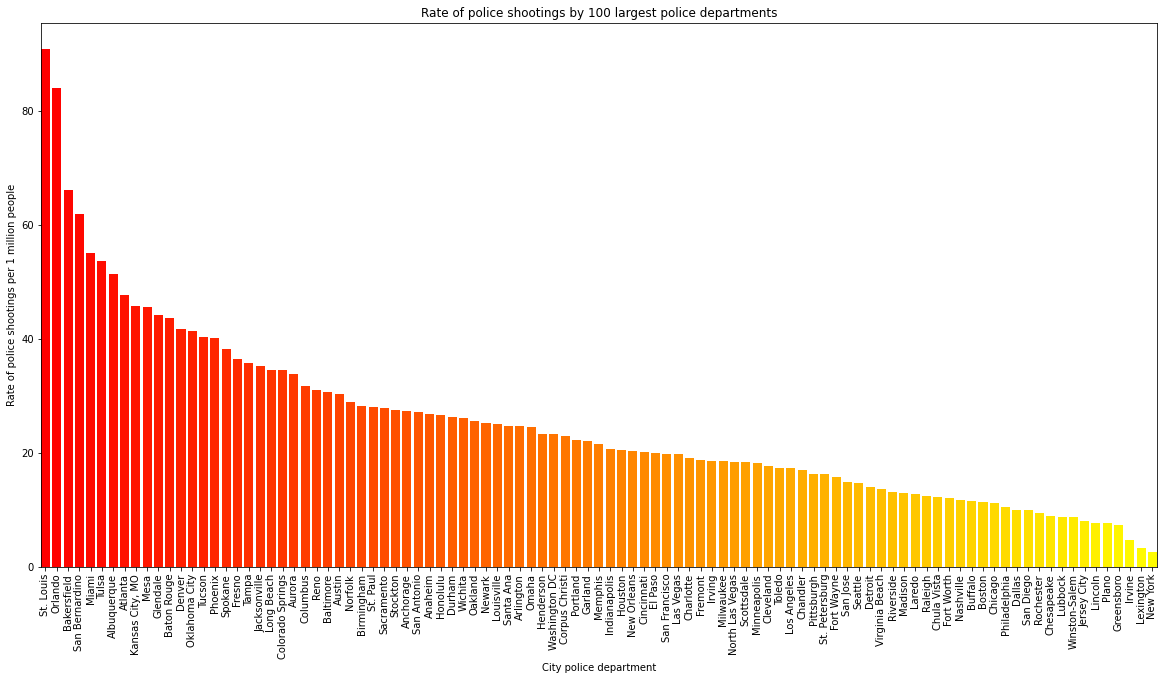

In [16]:
pd_100_shootings = {}

#use_of_force = pd.read_csv('data/use-of-force.csv')            

for city in city_df['Police Department'].values:
    this_state=city_df.loc[city_df['Police Department']==city,'state']
    if city in df.groupby('city').size().index: # matching names
        # need to pick the ones with the corect state
        pd_100_shootings[city] = df.groupby(['city','state']).size()[city][this_state].values[0]        
    elif city in (df['city']+ ', '+ df['state']).values: # Kansas City, MO
        pd_100_shootings[city] = len(df[(df['city']+ ', '+ df['state']) == city])
    elif city in (df['city']+ ' '+ df['state']).values: # Washington DC
        pd_100_shootings[city] = len(df[(df['city']+ ' '+ df['state']) == city])

# city_pop = pd.read_csv('/Users/kamranahmed/Downloads/cities.csv')
# use_of_force['POP'] = city_pop['POP']

city_df = city_df.join(pd.DataFrame(pd_100_shootings.values(), index=pd_100_shootings.keys(), columns=['Number of shootings']), on='Police Department',how='left')
city_df['shootings per 1M'] = (city_df['Number of shootings']/city_df['Total Population'])*1000000
city_df = city_df.sort_values(by=['shootings per 1M'], ascending=False)

plt.figure(figsize=(20,10))
plt.bar(city_df['Police Department'], city_df['shootings per 1M'], color = cmap.autumn(np.linspace(0, 1, len(city_df))))
plt.margins(x=0)
plt.xticks(rotation='vertical')
plt.xlabel('City police department')
plt.ylabel('Rate of police shootings per 1 million people')
plt.title('Rate of police shootings by 100 largest police departments');


The largest 100 city police department shootings account for 28.578% of all police shootings recorded since 2015.
2103 cities are recorded as having at least 1 police shooting in the Washington Post dataset.


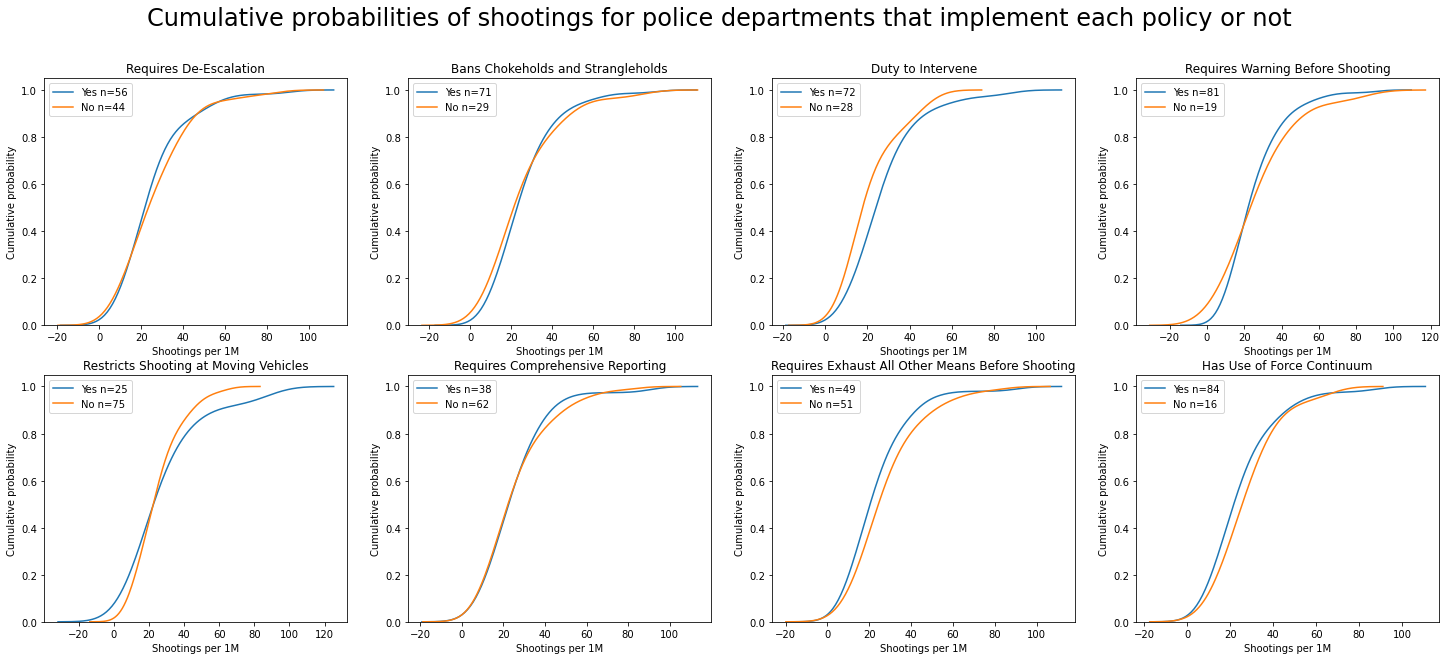

In [17]:
largest_100_perc_shootings = (city_df['Number of shootings'].sum() / len(df))*100
print(f'The largest 100 city police department shootings account for {round(largest_100_perc_shootings,3)}% of all police shootings recorded since 2015.')

num_cities = df['city'].value_counts()
print(f'{len(num_cities)} cities are recorded as having at least 1 police shooting in the Washington Post dataset.')

policies = ['Requires De-Escalation',
            'Bans Chokeholds and Strangleholds',
            'Duty to Intervene',
            'Requires Warning Before Shooting',
            'Restricts Shooting at Moving Vehicles',
            'Requires Comprehensive Reporting',
            'Requires Exhaust All Other Means Before Shooting',
            'Has Use of Force Continuum']


fig, ax = plt.subplots(2, 4, figsize=(25,10))

axs = ax.ravel()

for i, ax in enumerate(axs):
    policy = policies[i]

    policy_yes = city_df[city_df[policy] == 1]['shootings per 1M']
    policy_no = city_df[city_df[policy] == 0]['shootings per 1M']
    ax.set_title(policy)
    ax.set_xlabel('Shootings per 1M')
    ax.set_ylabel('Cumulative probability')
    sns.kdeplot(policy_yes, cumulative=True, label=f'Yes n={len(policy_yes)}', ax=ax)
    sns.kdeplot(policy_no, cumulative=True, label=f'No n={len(policy_no)}',  ax=ax)
    ax.legend()
fig.suptitle('Cumulative probabilities of shootings for police departments that implement each policy or not', fontsize=24);
#plt.savefig('use of force.png')

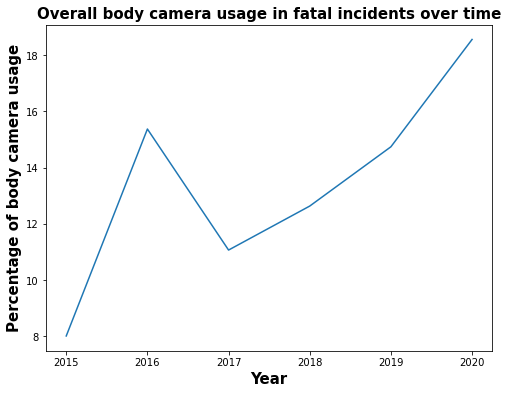

In [18]:
# overall body camera usage trend
year=pd.DatetimeIndex(df['date']).year
df.groupby(year)['body_camera'].value_counts()
year_bodycam=df.groupby(year).size().to_frame(name='total')
year_bodycam['body_cam_used']=df.groupby(year)['body_camera'].value_counts().unstack(fill_value=0)[True]
year_bodycam['percent_body_cam_used']=100*year_bodycam['body_cam_used']/year_bodycam['total']

fig,ax=plt.subplots(figsize=(8,6))
ax.plot(year_bodycam.index,year_bodycam['percent_body_cam_used'])
ax.set_title('Overall body camera usage in fatal incidents over time',fontweight='bold',fontsize=15)
ax.set_xlabel('Year',fontweight='bold',fontsize=15)
ax.set_ylabel('Percentage of body camera usage',fontweight='bold',fontsize=15);

### State-level analysis on body camera usage

In [19]:
# look at in what percent of incidencets the police officers had body cameras
overall_percent_body_cam=np.mean((df.body_camera==True)*1)*100
print(f'The police officers wore body cameras in {overall_percent_body_cam:.2f}% \
of the fatal police shooting incidents in this dataset.')

# how does body cam usage vary with geographic location (state level)
# create a new df named state_bodycam where for each state, we have total number of incidents and body cam usage
state_df=df.groupby('state').size().to_frame(name='total').copy()
state_df['body_cam_used']=df.groupby('state')['body_camera'].value_counts().unstack(fill_value=0)[True].copy()

# create new column of percent body cam used
state_df['percent_body_cam_used']=100*state_df['body_cam_used']/state_df['total']

# add population info to state_df
# since everything is sorted by alphabetical order of state names, can just add the column of state_populations.POPESTIMATE2019
state_df['population']=state_populations.POPESTIMATE2019.values.copy()

# sort by percent body cam used and display first 10 rows
#state_df.sort_values(by='percent_body_cam_used',ascending=False).head(10)

state_df['num_per_million']=1000000*state_df['total']/state_df['population']


The police officers wore body cameras in 12.93% of the fatal police shooting incidents in this dataset.


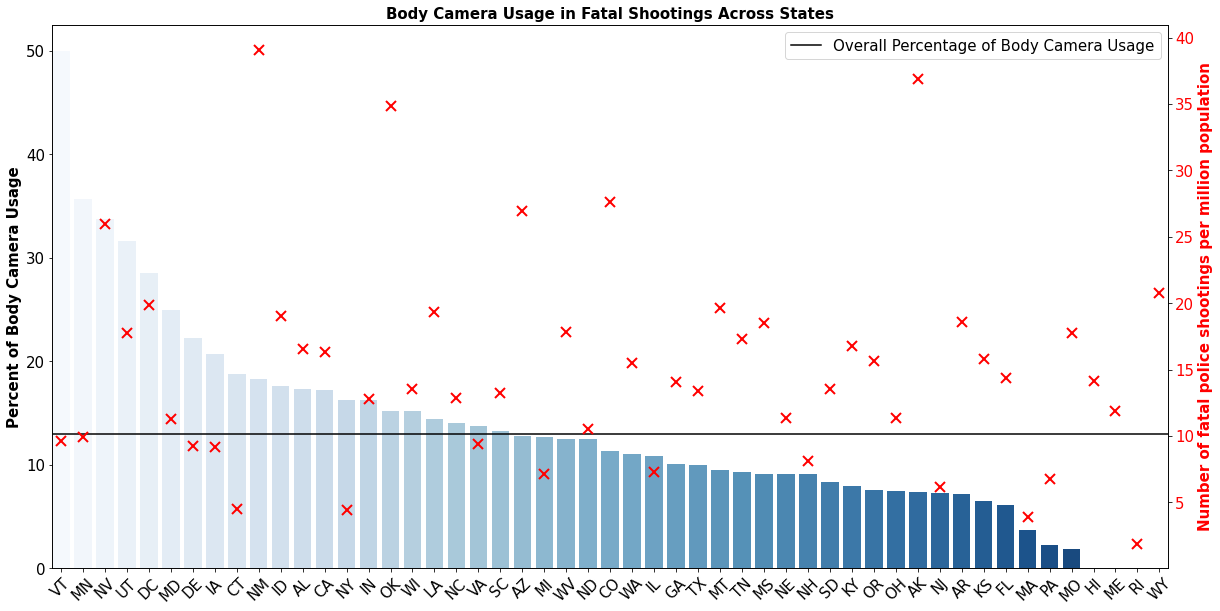

In [20]:
r_state=np.corrcoef(state_df['num_per_million'],state_df['percent_body_cam_used'])[0,1]

# display sorted bar graph of percent_body_cam_used in descending order of states
fig,ax=plt.subplots(figsize=(20,10))
order = state_df['percent_body_cam_used'].sort_values(ascending=False).index
sns.barplot(x=state_df.index,y=state_df['percent_body_cam_used'], order=order, ax=ax, palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=15);
ax.set_xlabel('')
ax.margins(x=0)
ax.set_ylabel('Percent of Body Camera Usage',fontweight='bold',fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title('Body Camera Usage in Fatal Shootings Across States',fontweight='bold',fontsize=15);
# draw a horizontal line of overall avg in the dataset
ax.axhline(y=overall_percent_body_cam,color='k',label='Overall Percentage of Body Camera Usage')
ax.legend(fontsize=15);

# second y axis showing shootings per million population 
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(order,state_df['num_per_million'][order],'x',color='r',markersize=10,markeredgewidth=2)
ax2.tick_params(axis='y', labelcolor='r',labelsize=15)
ax2.set_ylabel('Number of fatal police shootings per million population',fontweight='bold',fontsize=15,color='r');

# plt.savefig('State percent body cam usage blue & red.png')

### City-level analysis on body camera usage

In [21]:
pd_100_bodycam={} # how many times body cameras are used

for city in city_df['Police Department'].values:
    this_state=city_df.loc[city_df['Police Department']==city,'state']
    if city in df.groupby('city').size().index: # matching names
        # need to pick the ones with the corect state
        pd_100_bodycam[city] = \
        df.groupby(['city','state'])['body_camera'].value_counts().unstack(fill_value=0)[True][city][this_state].values[0]
        
    elif city in (df['city']+ ', '+ df['state']).values: # Kansas City, MO
        pd_100_bodycam[city] = sum(df[(df['city']+ ', '+ df['state']) == city]['body_camera']==True)
    elif city in (df['city']+ ' '+ df['state']).values: # Washington DC
        pd_100_bodycam[city] = sum(df[(df['city']+ ' '+ df['state']) == city]['body_camera']==True)    

# city_pop = pd.read_csv('/Users/kamranahmed/Downloads/cities.csv')
# use_of_force['POP'] = city_pop['POP']

city_df = city_df.join(pd.DataFrame(pd_100_bodycam.values(), index=pd_100_bodycam.keys(), columns=['Number of body cam usage']), on='Police Department')
city_df['percent body cam used']=100*city_df['Number of body cam usage']/city_df['Number of shootings']
city_df['shootings per 1M'] = (city_df['Number of shootings']/city_df['Total Population'])*1000000
city_df = city_df.sort_values(by=['shootings per 1M'], ascending=False)
city_df=city_df.dropna()

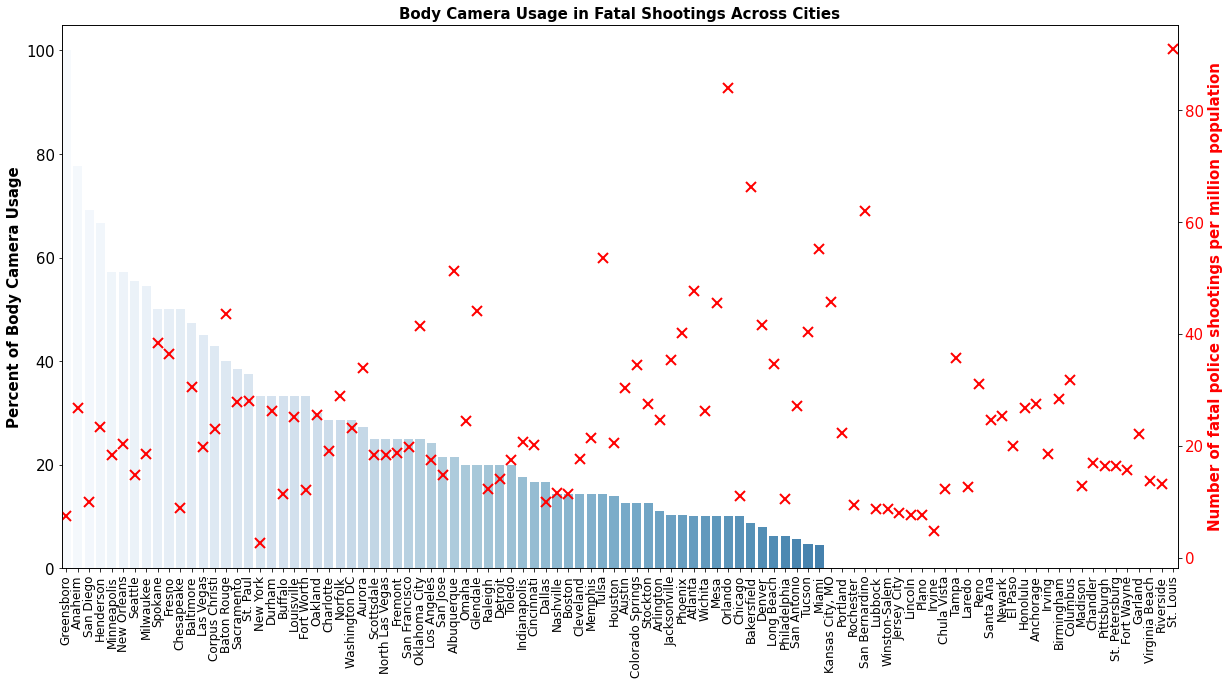

In [22]:
# display sorted bar graph of percent_body_cam_used in descending order of states
fig,ax=plt.subplots(figsize=(20,10))
order = city_df.sort_values(by='percent body cam used',ascending=False)
sns.barplot(x=order['Police Department'].values,y=order['percent body cam used'].values, ax=ax, palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=12);
ax.set_xlabel('')
ax.margins(x=0)
ax.set_ylabel('Percent of Body Camera Usage',fontweight='bold',fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title('Body Camera Usage in Fatal Shootings Across Cities',fontweight='bold',fontsize=15);
# draw a horizontal line of overall avg in the dataset
#ax.axhline(y=overall_percent_body_cam,color='k',label='Overall Percentage of Body Camera Usage')
#ax.legend(fontsize=15);

# second y axis showing shootings per million population 
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(order['Police Department'].values,order['shootings per 1M'].values,'x',color='r',markersize=10,markeredgewidth=2)
ax2.tick_params(axis='y', labelcolor='r',labelsize=15)
ax2.set_ylabel('Number of fatal police shootings per million population',fontweight='bold',fontsize=15,color='r');

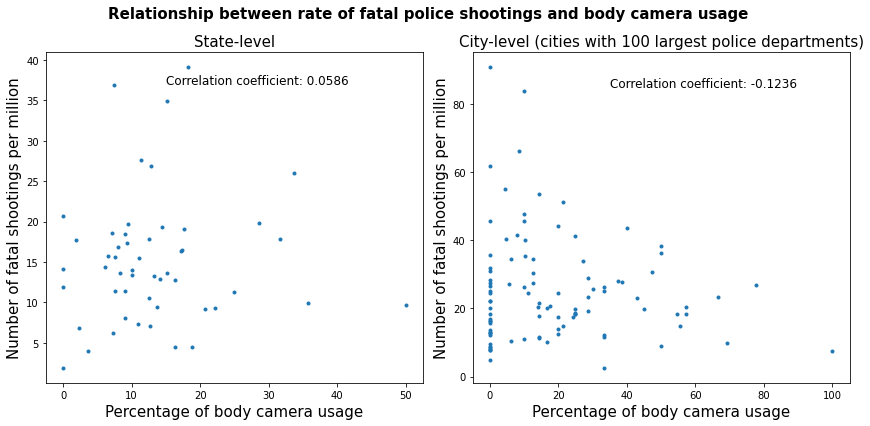

In [23]:
r_city=np.corrcoef(city_df['shootings per 1M'],city_df['percent body cam used'])[0,1]

# plot state and city together
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].plot(state_df['percent_body_cam_used'],state_df['num_per_million'],'.')
ax[0].set_title('State-level',fontsize=15)
ax[0].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[0].set_xlabel('Percentage of body camera usage',fontsize=15);
ax[0].text(15,37,f'Correlation coefficient: {r_state:.4f}',fontsize=12)

ax[1].plot(city_df['percent body cam used'],city_df['shootings per 1M'],'.')
ax[1].set_title('City-level (cities with 100 largest police departments)',fontsize=15)
ax[1].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[1].set_xlabel('Percentage of body camera usage',fontsize=15);
ax[1].text(35,85,f'Correlation coefficient: {r_city:.4f}',fontsize=12)

plt.suptitle('Relationship between rate of fatal police shootings and body camera usage',fontweight='bold',fontsize=15)
plt.tight_layout()

## EDA: LEMAS Data for body camera, police policy, and training

In [24]:
# 2016 LEMAS data
lemas_raw = pd.read_csv('data/LEMAS_2016.tsv', sep = '\t', index_col = 'LEAR_ID', header = 0, encoding = 'unicode_escape')

Potentially useful columns:

`LEAR_ID`

`AGENCYNAME`

`CITY`

`STATE`

`COUNTY`

`POPSERVED` - from 2016 census of populations

`FTSWORN` - Number of actual full-time sworn officers with arrest power

`POL_BWC` - AGENCY HAS WRITTEN POLICY OR PROCEDURAL DIRECTIVES ON: BODY-WORN CAMERAS
    
    1 Yes
    
    2 No

`PERS_TRN_ACAD` - TOTAL HOURS OF ACADEMY TRAINING REQUIRED FOR NEW OFFICER RECRUITS

`PERS_TRN_FIELD` - TOTAL HOURS OF FIELD TRAINING REQUIRED FOR NEW OFFICER RECRUITS

`CP_TRN_NEW` - PROPORTION OF AGENCY PERSONNEL RECEIVED AT LEAST EIGHT HOURS OF COMMUNITY POLICING TRAINING: NEW OFFICER RECRUITS (problem solving, SARA, or community partnerships)
    
    1 All
    
    2 Some
    
    3 None

`CP_TRN_INSRV` - PROPORTION OF AGENCY PERSONNEL RECEIVED AT LEAST EIGHT HOURS OF COMMUNITY POLICING TRAINING: IN-SERVICE SWORN PERSONNEL

    1 All
    
    2 Some
    
    3 None


`CP_SURV_TRAINING` -USE INFORMATION FROM SURVEY FOR: TRAINING DEVELOPMENT
    
    1 Yes
    
    2 No
    

`PERS_EDU_MIN `- INDICATE YOUR AGENCY'S MINIMUM EDUCATION REQUIREMENT WHICH NEW OFFICER RECRUITS MUST HAVE AT HIRING OR WITHIN TWO YEARS OF HIRING
    
    1 4-yr college required
    
    2 2-yr college required
    
    3 some college but no degree
    
    4 high school diploma or equivalent
    
    5 no formal education requirement

*-9 denotes missing data*

*-8 means N/A*

In [45]:
lemas_columns_to_keep=['AGENCYNAME','CITY','STATE','COUNTY','POPSERVED','FTSWORN','POL_BWC',
                 'PERS_TRN_ACAD','PERS_TRN_FIELD','CP_TRN_NEW','CP_TRN_INSRV','CP_SURV_TRAINING','PERS_EDU_MIN']
lemas=lemas_raw[lemas_columns_to_keep].copy()

# we know missing data are -9 and -8, replace them with nan
lemas=lemas.replace([-9,-8],np.nan)

Some columns have a lot of missing data, for now let's focus on the more complete columns that are also more relevant: POL_BWC, PERS_TRN_ACAD, PERS_TRN_FIELD

In [26]:
lemas_training=lemas[['AGENCYNAME','CITY','STATE','COUNTY','FTSWORN','PERS_TRN_ACAD','PERS_TRN_FIELD']].copy()
# drop rows with nan (where we don't have information on training data)
lemas_training=lemas_training.dropna(axis=0)
# drop agencies with 0 sworn officers
lemas_training=lemas_training.loc[lemas_training['FTSWORN']>0]

# for each state, calculate the average trainig hours required for academy and field training for each officer
print(f'Number of states present: {len(lemas_training.STATE.unique())}')
# 50 states + DC

# total number of sworn officers
state_df['sworn_officers']=lemas_training.groupby('STATE')['FTSWORN'].sum()
state_df['avg_training_acad']=''
state_df['avg_training_field']=''

for this_state in lemas_training.STATE.unique():
    total_training_acad=sum(lemas_training.loc[lemas_training['STATE']==this_state]['FTSWORN']\
                            *lemas_training.loc[lemas_training['STATE']==this_state]['PERS_TRN_ACAD'])
    total_training_field=sum(lemas_training.loc[lemas_training['STATE']==this_state]['FTSWORN']\
                            *lemas_training.loc[lemas_training['STATE']==this_state]['PERS_TRN_FIELD'])
    
    state_df.loc[this_state,'avg_training_acad']=total_training_acad/state_df.loc[this_state,'sworn_officers']
    state_df.loc[this_state,'avg_training_field']=total_training_field/state_df.loc[this_state,'sworn_officers']

state_df['avg_training_acad']=state_df['avg_training_acad'].astype(float)
state_df['avg_training_field']=state_df['avg_training_field'].astype(float)

state_df.head()

Number of states present: 51


total  body_cam_used  percent_body_cam_used  population  \
state                                                            
AK        27              2               7.407407      731545   
AL        81             14              17.283951     4903185   
AR        56              4               7.142857     3017804   
AZ       196             25              12.755102     7278717   
CA       644            111              17.236025    39512223   

       num_per_million  sworn_officers  avg_training_acad  avg_training_field  
state                                                                          
AK           36.908187             477         896.708595          701.651992  
AL           16.519874            5260         621.734981          516.204563  
AR           18.556540            3202         684.245784          476.430356  
AZ           26.927823            8982         880.287018          600.017813  
CA           16.298754           50495         931.691653         1069.865947

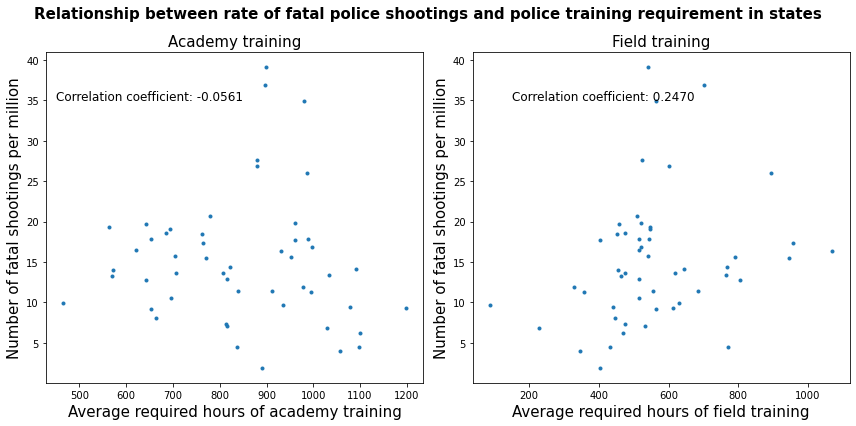

In [27]:
# correlation coefficients
r_train_acad_state=np.corrcoef(state_df['num_per_million'],state_df['avg_training_acad'])[0,1]
r_train_field_state=np.corrcoef(state_df['num_per_million'],state_df['avg_training_field'])[0,1]

# plot for state level, how academy and field training affect rate of fatal shooting
fig,ax=plt.subplots(1,2,figsize=(12,6))

ax[0].plot(state_df['avg_training_acad'],state_df['num_per_million'],'.')
ax[0].set_title('Academy training',fontsize=15)
ax[0].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[0].set_xlabel('Average required hours of academy training',fontsize=15);
ax[0].text(450,35,f'Correlation coefficient: {r_train_acad_state:.4f}',fontsize=12)

ax[1].plot(state_df['avg_training_field'],state_df['num_per_million'],'.')
ax[1].set_title('Field training',fontsize=15)
ax[1].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[1].set_xlabel('Average required hours of field training',fontsize=15);
ax[1].text(150,35,f'Correlation coefficient: {r_train_field_state:.4f}',fontsize=12)

plt.suptitle('Relationship between rate of fatal police shootings and police training requirement in states',fontweight='bold',fontsize=15)
plt.tight_layout()

In [28]:
lemas_training['CITY']=lemas_training['CITY'].str.title()
city_df['sworn_officers']=''
city_df['avg_training_acad']=''
city_df['avg_training_field']=''
manual_city=list()
missing_city=list()

for ind, this_city in enumerate(city_df['Police Department'].values):
    if this_city in np.array(lemas_training.CITY): 
        # if there's correct city and state correspondence
        # extract relevant rows of lemas_training
        this_state=city_df['state'].iloc[ind]
        temp_df=lemas_training.loc[(lemas_training['CITY']==this_city) & (lemas_training['STATE']==this_state)].copy()
        if len(temp_df)>0:
            total_training_acad=sum(temp_df['FTSWORN']*temp_df['PERS_TRN_ACAD'])
            total_training_field=sum(temp_df['FTSWORN']*temp_df['PERS_TRN_FIELD'])
            city_df.loc[city_df['Police Department']==this_city,'sworn_officers']=sum(temp_df['FTSWORN'])
            city_df.loc[city_df['Police Department']==this_city,'avg_training_acad']=total_training_acad/sum(temp_df['FTSWORN'])
            city_df.loc[city_df['Police Department']==this_city,'avg_training_field']=total_training_field/sum(temp_df['FTSWORN'])
        else: # city exists but not the right combo with state
            missing_city.append(this_city)
    else: # city may be missing or have mismatched names
         manual_city.append(this_city)

print('Missing cities (no match for city + state combo): ')
print(missing_city)
print('\nManually check: ')
print(manual_city)

Missing cities (no match for city + state combo): 
['Miami']

Manually check: 
['St. Louis', 'Kansas City, MO', 'St. Paul', 'Washington DC', 'St. Petersburg', 'Fort Wayne', 'Philadelphia', 'Winston-Salem']


In [29]:
# check that Miami is indeed missing
#display(lemas_training.loc[lemas_training['CITY']=='Miami'][['CITY','STATE']])
#display(city_df.loc[city_df['Police Department']=='Miami'][['Police Department','state']])

# manually fix mismatched cities 
#display(city_df.iloc[np.where(np.isin(city_df['Police Department'].values,manual_city))][['Police Department','state']])
#display(lemas_training.iloc[np.where(lemas_training.CITY.str.contains('louis|kansas|paul|washington|petersburg|wayne|philadelphia|winston',case=False))])

def fix_cities(lemas_city_name,city_df_city_name,state_name):
    temp_df=lemas_training.loc[(lemas_training['CITY']==lemas_city_name) & (lemas_training['STATE']==state_name)].copy()
    total_training_acad=sum(temp_df['FTSWORN']*temp_df['PERS_TRN_ACAD'])
    total_training_field=sum(temp_df['FTSWORN']*temp_df['PERS_TRN_FIELD'])
    city_df.loc[city_df['Police Department']==city_df_city_name,'sworn_officers']=sum(temp_df['FTSWORN'])
    city_df.loc[city_df['Police Department']==city_df_city_name,'avg_training_acad']=total_training_acad/sum(temp_df['FTSWORN'])
    city_df.loc[city_df['Police Department']==city_df_city_name,'avg_training_field']=total_training_field/sum(temp_df['FTSWORN'])
    return city_df

# 'St. Louis'
city_df=fix_cities('Saint Louis','St. Louis','MO')
#display(city_df.loc[city_df['Police Department']=='St. Louis'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'St. Paul'
city_df=fix_cities('Saint Paul','St. Paul','MN')
#display(city_df.loc[city_df['Police Department']=='St. Paul'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'St. Petersburg'
city_df=fix_cities('Saint Petersburg','St. Petersburg','FL')
#display(city_df.loc[city_df['Police Department']=='St. Petersburg'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'Kansas City, MO'
city_df=fix_cities('Kansas City','Kansas City, MO','MO')
#display(city_df.loc[city_df['Police Department']=='Kansas City, MO'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'Washington DC'
city_df=fix_cities('Washington','Washington DC','DC')
#display(city_df.loc[city_df['Police Department']=='Washington DC'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'Winston-Salem'
city_df=fix_cities('Winston Salem','Winston-Salem','NC')
#display(city_df.loc[city_df['Police Department']=='Winston-Salem'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# convert these columns to numeric
city_df[['sworn_officers','avg_training_acad','avg_training_field']]\
=city_df[['sworn_officers','avg_training_acad','avg_training_field']].apply(pd.to_numeric,errors='coerce')

# expect 3 missing values for Miami, Fort Wayne, Philaphdelphia
print(np.sum(city_df[['sworn_officers','avg_training_acad','avg_training_field']].isnull()))

# drop rows with nan 
city_df=city_df.dropna(axis=0)

sworn_officers        3
avg_training_acad     3
avg_training_field    3
dtype: int64


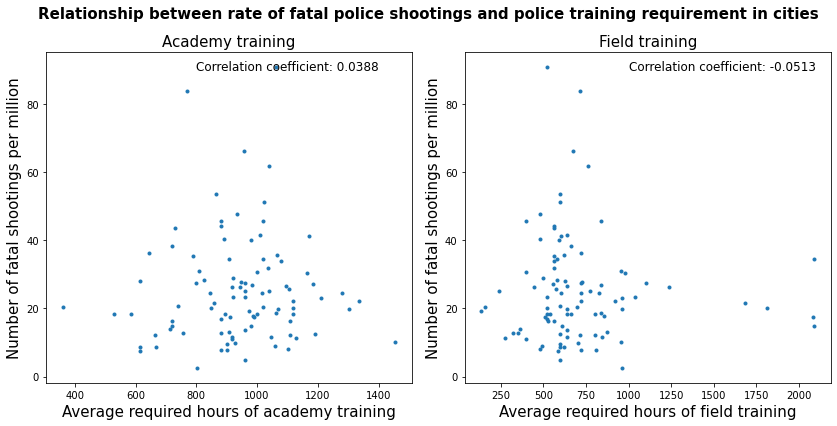

In [30]:
# correlation coefficients
r_train_acad_city=np.corrcoef(city_df['shootings per 1M'],city_df['avg_training_acad'])[0,1]
r_train_field_city=np.corrcoef(city_df['shootings per 1M'],city_df['avg_training_field'])[0,1]

# now we have 96 cities out of 100 with trainig info
# plot for city level, how academy and field training affect rate of fatal shooting
fig,ax=plt.subplots(1,2,figsize=(12,6))

ax[0].plot(city_df['avg_training_acad'],city_df['shootings per 1M'],'.')
ax[0].set_title('Academy training',fontsize=15)
ax[0].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[0].set_xlabel('Average required hours of academy training',fontsize=15);
ax[0].text(800,90,f'Correlation coefficient: {r_train_acad_city:.4f}',fontsize=12)

ax[1].plot(city_df['avg_training_field'],city_df['shootings per 1M'],'.')
ax[1].set_title('Field training',fontsize=15)
ax[1].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[1].set_xlabel('Average required hours of field training',fontsize=15);
ax[1].text(1000,90,f'Correlation coefficient: {r_train_field_city:.4f}',fontsize=12)

plt.suptitle('Relationship between rate of fatal police shootings and police training requirement in cities',fontweight='bold',fontsize=15)
plt.tight_layout()

## EDA: Police Department-wise and county-level analysis

In [31]:
xls = pd.ExcelFile('data/MPVDatasetDownload_CleanColumnNames.xlsx')
#ew is event-wise 
df = pd.read_excel(xls, sheet_name='2013-2020 Police Killings')
killings_by_pd = pd.read_excel(xls,sheet_name='2013-2019 Killings by PD')
killings_by_state = pd.read_excel(xls,sheet_name='2013-2019 Killings by State')

df.head()

victim_name victim_age victim_gender   victim_race  \
0              Bennie Biby         44          Male  Unknown race   
1   Clifton Gorman Spencer         35          Male  Unknown race   
2  Name withheld by police        NaN          Male  Unknown race   
3        Michael K. Nelson         27          Male  Unknown race   
4       Walter Wallace Jr.         27          Male         Black   

  image_of_victim       date        street_address          city state_code  \
0             NaN 2020-10-28                   NaN  Trigg County         KY   
1             NaN 2020-10-27                   NaN   Chattanooga         TN   
2             NaN 2020-10-27  5300 W. Solafax Lane      Herriman         UT   
3             NaN 2020-10-26                   NaN    Alexandria         VA   
4             NaN 2020-10-26                   NaN  Philadelphia         PA   

   zipcode  ...            armed        weapon  threat_level      fleeing  \
0      NaN  ...  Allegedly Armed  undetermined  undetermined          NaN   
1      NaN  ...  Allegedly Armed           gun         other          NaN   
2  84096.0  ...  Allegedly Armed  undetermined  undetermined          NaN   
3      NaN  ...  Allegedly Armed           gun        attack         foot   
4      NaN  ...  Allegedly Armed         knife         other  not fleeing   

  body_camera wapo_id off_duty geography MPV_ID fatal_encounters_id  
0          No  6271.0      NaN       NaN    NaN                 NaN  
1          No  6269.0      NaN       NaN    NaN                 NaN  
2          No  6268.0      NaN  Suburban    NaN                 NaN  
3          No  6270.0      NaN       NaN    NaN                 NaN  
4          No  6266.0      NaN       NaN    NaN                 NaN  

[5 rows x 29 columns]

In [32]:
def get_victim_stats(df):
    
    # takes in MPV dataframe and returns stats computed on select columns
    
    n = df.shape[0]
    
    vic_stats = {'n_victims': n}
    
    vic_stats['n_victims'] = n
    vic_stats['n_unarmed'] = (df.armed=='Unarmed/Did Not Have an Actual Weapon').mul(1).sum()
    vic_stats['n_armed'] = (df.armed=='Allegedly Armed').mul(1).sum()
    vic_stats['n_white'] = (df.victim_race=='White').mul(1).sum()
    vic_stats['n_black'] = (df.victim_race=='Black').mul(1).sum()
    vic_stats['n_hispanic'] = (df.victim_race=='Hispanic').mul(1).sum()
    
    ages = pd.to_numeric(df.victim_age,errors='coerce')
    ages = ages.dropna().values
    vic_stats['mean_age'] = np.mean(ages)
    
    vic_stats['frac_unarmed'] = vic_stats['n_unarmed']/n
    vic_stats['frac_white'] = vic_stats['n_white']/n
    vic_stats['frac_black'] = vic_stats['n_black']/n
    vic_stats['frac_hispanic'] = vic_stats['n_hispanic']/n
        
    return vic_stats

In [33]:
# load more data 

# df demographic info from US census
df_demo = pd.read_csv('data/acs2015_county_data.csv')


# election data from HW 1
df_election = pd.read_csv('data/election2016_by_county.csv')


# load LEMAS
lemas_raw = pd.read_csv('data/LEMAS_2016.tsv', sep = '\t', index_col = 'LEAR_ID', header = 0, encoding = 'unicode_escape')


race_fields = ['WHITE','BLACK','HISP','AMIND','ASIAN','HAWPI','MULTI','UNK']
gender_fields = ['MALE','FEM']

# remove rows that do not have demographic info
lemas_raw = lemas_raw.loc[(lemas_raw.PERS_MALE>=0) & (lemas_raw.PERS_FEMALE>=0) & (lemas_raw.PERS_WHITE_FEM>=0) & (lemas_raw.PERS_WHITE_MALE>=0)]


lemas_raw['PERS_TOTAL'] = lemas_raw.PERS_MALE + lemas_raw.PERS_FEMALE

# for now, take a fraction of the columns or it is overwhelming...
# EDIT:
lemas_new = lemas_raw.iloc[:,0:10]



lemas_new['PERS_TOTAL'] = lemas_raw.PERS_MALE + lemas_raw.PERS_FEMALE
lemas_new['PERS_WHITE'] = lemas_raw.PERS_WHITE_MALE + lemas_raw.PERS_WHITE_FEM
lemas_new['FRAC_WHITE'] = lemas_new.PERS_WHITE/lemas_new.PERS_TOTAL

# create FIPS code column for merging
df_demo['FIPS'] = df_demo.CensusId
df_election['FIPS'] = df_election.fipscode
df_election = df_election[['FIPS','trump','clinton','votergap','density']]

# make LEMAS FIPS CODE NUMERIC
lemas_new.FIPS = pd.to_numeric(lemas_new.FIPS,errors='coerce')
lemas_new = lemas_new.dropna()

# REMOVE STATE AGENCIES FOR NOW BECAUSE DEMOGRAPHICS HAVE NOT BEEN COMPUTED ON STATE-WIDE LEVEL
# Also, only 18 state agencies have had shooting victims, and count is relatively low, so we are not excluding a huge amount of useful data

lemas_new = lemas_new[lemas_new.AGENCYTYPE<3]

# merge county-level voter and demographic data into lemas new

lemas_new = lemas_new.merge(df_demo,how='left',on='FIPS')
lemas_new = lemas_new.merge(df_election,how='left',on='FIPS')

# for every police department, compute victim stats

vic_stats_all = []

for ind,row in lemas_new.iterrows():
    ori_id = row['ORI9']
    # find victims
    vic = df[df.ORI_agency_id==ori_id]
    vic_stats = get_victim_stats(vic)
    vic_stats['ORI9'] = ori_id
    vic_stats_all.append(vic_stats)

pd_vic_stats = pd.DataFrame(vic_stats_all)

lemas_new = lemas_new.merge(pd_vic_stats,how='left',on='ORI9')


print(f'fraction of police departments (not state-level) responsible for at least one fatality: {(pd_vic_stats.n_victims>0).mul(1).mean():.4f}')


print('Statistics for victims of police departments, for police departments with at least 1 shooting:')
# look at stats for only police departments with at least one shooting / killing
pd_vic_stats[pd_vic_stats.n_victims>0].describe()

/opt/anaconda3/envs/cs109/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/opt/anaconda3/envs/cs109/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/opt/anaconda3/envs/cs109/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning:

invalid value encountered in long_scalars

/opt/anaconda3/envs/cs109/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in long_scalars

/opt/anaconda3/envs/cs109/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

invalid value encountered in long_scalars

/opt/anaconda3/envs/cs109/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in long_scalars



fraction of police departments (not state-level) responsible for at least one fatality: 0.3253
Statistics for victims of police departments, for police departments with at least 1 shooting:


n_victims   n_unarmed     n_armed     n_white     n_black  n_hispanic  \
count  827.000000  827.000000  827.000000  827.000000  827.000000  827.000000   
mean     5.302297    0.787183    3.830713    1.827086    1.662636    1.094317   
std     10.092216    1.752392    7.477675    2.743752    4.471984    4.163813   
min      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
50%      2.000000    0.000000    2.000000    1.000000    0.000000    0.000000   
75%      5.000000    1.000000    4.000000    2.000000    1.000000    1.000000   
max    132.000000   22.000000  103.000000   31.000000   58.000000   76.000000   

         mean_age  frac_unarmed  frac_white  frac_black  frac_hispanic  
count  817.000000    827.000000  827.000000  827.000000     827.000000  
mean    36.890885      0.145968    0.468109    0.252349       0.140668  
std      9.772811      0.262183    0.403163    0.343915       0.265087  
min      1.000000      0.000000    0.000000    0.000000       0.000000  
25%     31.000000      0.000000    0.000000    0.000000       0.000000  
50%     35.843750      0.000000    0.428571    0.000000       0.000000  
75%     41.294118      0.200000    1.000000    0.500000       0.174797  
max     76.000000      1.000000    1.000000    1.000000       1.000000

In [34]:
print('Police departments with at least 10 victims, sorted by fractionof victims that are unarmed (top 10 shown):')

lemas_new[lemas_new.n_victims>=10].sort_values('frac_unarmed',ascending=False).head(10)

Police departments with at least 10 victims, sorted by fractionof victims that are unarmed (top 10 shown):


AGENCYNAME             CITY  ZIPCODE STATE  \
553         CLEVELAND POLICE DEPARTMENT        CLEVELAND    44113    OH   
2554       PRINCE GEORGES COUNTY POLICE      HYATTSVILLE    20785    MD   
2571  SAN DIEGO COUNTY SHERIFF'S OFFICE        SAN DIEGO    92193    CA   
2569          ATLANTA POLICE DEPARTMENT          ATLANTA    30303    GA   
2539      PASCO COUNTY SHERIFF'S OFFICE  NEW PORT RICHEY    34654    FL   
2551           FRESNO POLICE DEPARTMENT           FRESNO    93721    CA   
2316        ARLINGTON POLICE DEPARTMENT        ARLINGTON    76011    TX   
2469       SACRAMENTO POLICE DEPARTMENT       SACRAMENTO    95822    CA   
2385          ANAHEIM POLICE DEPARTMENT          ANAHEIM    92803    CA   
2197         BILLINGS POLICE DEPARTMENT         BILLINGS    59103    MT   

               COUNTY     FIPS       ORI9  POPSERVED  POPGROUP  AGENCYTYPE  \
553          CUYAHOGA  39035.0  OHCLP0000     385809         3           1   
2554  PRINCE GEORGE'S  24033.0  MD0172100     693100         2           1   
2571        SAN DIEGO   6073.0  CA0370000    3317749         1           2   
2569           FULTON  13121.0  GAAPD0000     439856         3           1   
2539            PASCO  12101.0  FL0510000     512368         2           2   
2551           FRESNO   6019.0  CA0100500     522053         2           1   
2316                   48439.0  TX2200100     392772         3           1   
2469       SACRAMENTO   6067.0  CA0340400     495234         3           1   
2385           ORANGE   6059.0  CA0300100     351043         3           1   
2197      YELLOWSTONE  30111.0  MT0560100     110323         4           1   

      ...  n_unarmed  n_armed  n_white  n_black n_hispanic   mean_age  \
553   ...          5        5        1       10          0  29.818182   
2554  ...          5        9        0       13          1  30.714286   
2571  ...          7       10        6        2         10  37.722222   
2569  ...          6       10        1       16          0  29.764706   
2539  ...          4        6        9        2          0  43.181818   
2551  ...          8       18        5        1         16  34.520000   
2316  ...          4        7        3        7          1  29.666667   
2469  ...          4        9        6        6          1  36.428571   
2385  ...          4        7        3        3          8  31.714286   
2197  ...          3        6        7        0          1  31.400000   

      frac_unarmed  frac_white  frac_black  frac_hispanic  
553       0.454545    0.090909    0.909091       0.000000  
2554      0.357143    0.000000    0.928571       0.071429  
2571      0.350000    0.300000    0.100000       0.500000  
2569      0.333333    0.055556    0.888889       0.000000  
2539      0.333333    0.750000    0.166667       0.000000  
2551      0.307692    0.192308    0.038462       0.615385  
2316      0.307692    0.230769    0.538462       0.076923  
2469      0.285714    0.428571    0.428571       0.071429  
2385      0.285714    0.214286    0.214286       0.571429  
2197      0.272727    0.636364    0.000000       0.090909  

[10 rows x 65 columns]

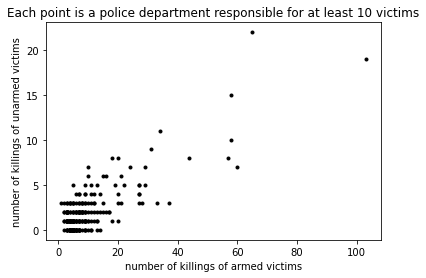

In [35]:
include = lemas_new.n_victims>=5

plt.plot(lemas_new.n_armed[include], lemas_new.n_unarmed[include],'k.')
plt.xlabel('number of killings of armed victims')
plt.ylabel('number of killings of unarmed victims')
plt.title('Each point is a police department responsible for at least 10 victims');

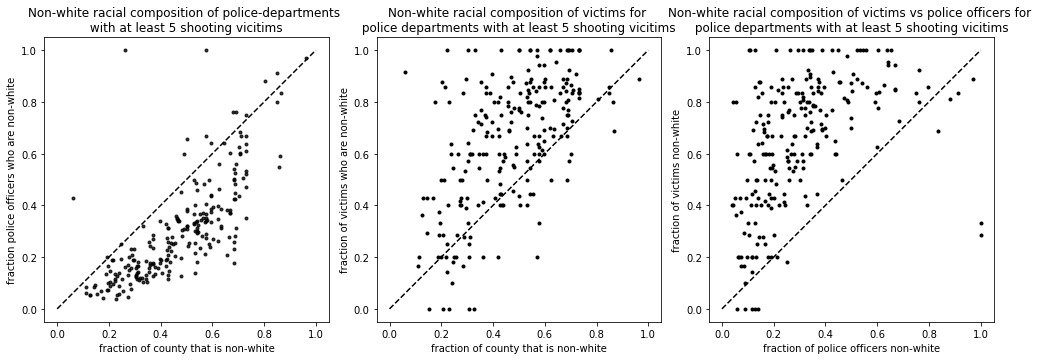

In [36]:
include = lemas_new.n_victims>=5


fig, ax = plt.subplots(1,3,figsize=(14, 5))
ax = ax.flatten()

ax[0].plot(1-(lemas_new.White[include]/100), 1-lemas_new.FRAC_WHITE[include],'k.',color='black',alpha=0.8)
ax[0].set(xlabel= 'fraction of county that is non-white',ylabel='fraction police officers who are non-white',aspect='equal',
          title='Non-white racial composition of police-departments \n with at least 5 shooting vicitims ')
ax[0].plot([0,1],[0,1],'k--', color='black')


ax[1].plot(1-lemas_new.White[include]/100, 1-lemas_new.frac_white[include],'k.')
ax[1].set(xlabel= 'fraction of county that is non-white',ylabel='fraction of victims who are non-white',aspect='equal',
         title='Non-white racial composition of victims for \n police departments with at least 5 shooting vicitims ')
ax[1].plot([0,1],[0,1],'k--', color='black')

ax[2].plot(1-lemas_new.FRAC_WHITE[include], 1-lemas_new.frac_white[include],'k.')
ax[2].set(xlabel= 'fraction of police officers non-white',ylabel='fraction of victims non-white', aspect='equal',
         title='Non-white racial composition of victims vs police officers for \n police departments with at least 5 shooting vicitims ')
ax[2].plot([0,1],[0,1],'k--', color='black')


plt.tight_layout()
plt.savefig('race_pd_vic_scatter.pdf',dpi=300)

## Cleaning data and matching each victim to a police department

In [ ]:
## FUNCTION DEF

# clean mpv data
def clean_mpv(mpv_df):

    # first only include rows with non-null wapo_id AND non-null ORI agency ID
    keep_rows = mpv_df.wapo_id.isnull()==False
    mpv_df = mpv_df[keep_rows][:].copy()

    # go through all ORI id and if there is more than one PD, keep first
    
    mpv_df['ORI_id_first'] =  ''
    for index,row in mpv_df.iterrows():
        ori_id_list = unpack_ori_id_list(row.ORI_agency_id,row.police_department)
        mpv_df.loc[index,'ORI_id_first'] = ori_id_list[0]

    # keep subset of columns
    keep_cols = ['wapo_id','street_address','city','state_code',
                 'zipcode','county','police_department','ORI_agency_id','ORI_id_first','armed','geography','armed']
    mpv_df_clean = mpv_df.loc[:,keep_cols]
    # add back wapo_id
    mpv_df_clean.loc[:,'wapo_id'] = mpv_df_clean.wapo_id.astype(int)

    # find duplicate wapo ids in mpv and exclude those rows
    duplicate_wapo_ids = mpv_df_clean.wapo_id.value_counts()
    duplicate_wapo_ids = duplicate_wapo_ids.index[duplicate_wapo_ids>1].values
    keep_rows = [not(x in duplicate_wapo_ids) for x in mpv_df_clean.wapo_id.values]
    mpv_df_clean = mpv_df_clean.loc[keep_rows,:]
    mpv_df_clean['ORI9'] = mpv_df['ORI_id_first']
    
    return mpv_df_clean


def clean_mpv_ori9_codes(mpv_df,lemas_geocode):
    
    # 
    mpv_df['ORI9_clean'] = ''
    mpv_df['ORI9_match_type'] = 0 #0:no match, #1:exact ORI9 match #2:PD & state match #3:state&county match #4: nearest lat&lon match

    non_match = {'ori9': [], 'pd_name':[]}

    for row_ind in range(mpv_df.shape[0]):
        row = mpv_df.iloc[row_ind,:]
        mpv_df.iloc[row_ind,:] = find_best_pd_match(row,lemas_geocode)
        
    return mpv_df
        

        
def find_best_pd_match(row,lemas_geocode):
    # Finds the best match for a police department, given a row with information about the victim:

    lemas_ori9 = lemas_geocode.ORI9.to_list()
    lemas_pd_names = lemas_geocode.AGENCYNAME.to_list()
    lemas_state = lemas_geocode.STATE.to_list()
    lemas_county = lemas_geocode.COUNTY.to_list()
    lemas_lat = lemas_geocode.lat.to_list()
    lemas_lng = lemas_geocode.lng.to_list()
    

    if not(isinstance(row.ORI_agency_id,str) and isinstance(row.police_department,str)):
        row.ORI9_clean = np.nan
        row.ORI9_match_type = 0
        return row

    if row.ORI_id_first in lemas_ori9:
        # exact match
        row.ORI9_clean = row.ORI_id_first
        row.ORI9_match_type = 1
        return row

    # unpack all ORI ids
    ori_ids, pd_names = unpack_ori_id_list(row.ORI_agency_id,row.police_department)
    for k in range(len(ori_ids)):
        if ori_ids[k] in lemas_ori9:
            row.ORI9_clean = ori_ids[k]
            row.ORI9_match_type = 1
            return row
        

    # otherwise, check for pd deparment name and state match:
    for this_pd_name in (pd_names):
         if this_pd_name.upper().strip() in lemas_pd_names:
                # potnetial match
                pd_match = [x==this_pd_name.upper().strip() for x in lemas_pd_names]
                state_match = [x==row.state_code for x in lemas_state]
                match_ind = np.argwhere(np.logical_and(pd_match,state_match)*1).flatten()
                if match_ind.shape[0]>0:
                    row.ORI9_clean = lemas_ori9[match_ind[0]]
                    row.ORI9_match_type = 2
                    return row
    
    if (isinstance(row.county,str) and isinstance(row.state_code,str)):     

        # otherwise check for county and state match
        county_match = np.array([x==row.county.upper().strip() for x in lemas_county])
        state_match = np.array([x==row.state_code.upper().strip() for x in lemas_state])
        both_match = np.argwhere(np.logical_and(county_match,state_match)*1).flatten()
        if both_match.shape[0]==1:
            print(f' state and county single match {both_match}')
            row.ORI9_clean = lemas_ori9[both_match[0]]
            row.ORI9_match_type = 3
            return row

    # no exact match, finally check lat and long distance
    if np.isnan(row.latitude):
        # nothing we can do...
        row.ORI9_clean = np.nan
        row.ORI9_match_type = -1
        return row
    else:
        incident_coord = (row.latitude,row.longitude)
        distances = []
        for pd_ind in range(len(lemas_lat)):
            if row.state==lemas_state[pd_ind]:
                pd_coord = (lemas_lat[pd_ind],lemas_lng[pd_ind])
                this_dist = distance.distance(incident_coord, pd_coord).km
            else:
                this_dist= 100000
            distances.append(this_dist)
            
        min_dist_ind = np.argmin(distances)
        print(f'closest pd: {distances[min_dist_ind]:.2f} km')
        if distances[min_dist_ind]<242:
            # if closest in-state PD is less than 150 miles away, consider it a match
            row.ORI9_clean = lemas_ori9[min_dist_ind]
            row.ORI9_match_type = 4
            return row
        else:
            row.ORI9_clean = np.nan
            row.ORI9_match_type = -2
            return row


def unpack_ori_id_list(ori_string,pd_string):
    # parses string with multiple PDs and ORI9 codes into a list
    if ';' in ori_string:
        ori_ids = ori_string.split(';')
    else:
        ori_ids = ori_string.split(',')
    
    if ',' in pd_string:
        pd_names = pd_string.split(',')
    else:
        pd_names = pd_string.split(';')
        
    return ori_ids, pd_names


# extract relevant stats for LEMAS - MORE SHOULD BE DONE HERE
def clean_lemas(lemas_raw):
    race_fields = ['WHITE','BLACK','HISP','AMIND','ASIAN','HAWPI','MULTI','UNK']
    gender_fields = ['MALE','FEM']

    # remove rows that do not have demographic info
    #lemas_raw = lemas_raw[(lemas_raw.PERS_MALE>=0) & (lemas_raw.PERS_FEMALE>=0) & (lemas_raw.PERS_WHITE_FEM>=0) & (lemas_raw.PERS_WHITE_MALE>=0)][:]


    lemas_raw['PERS_TOTAL'] = lemas_raw.PERS_MALE + lemas_raw.PERS_FEMALE

    # for now, take a fraction of the columns or it is overwhelming...
    # EDIT:
    lemas_new = lemas_raw.iloc[:,0:10]

    lemas_new['PERS_TOTAL'] = lemas_raw.PERS_MALE + lemas_raw.PERS_FEMALE
    
    for this_race in race_fields:
        lemas_new['PERS_' + this_race] = lemas_raw['PERS_' + this_race + '_MALE'] + lemas_raw['PERS_' + this_race + '_FEM']
        lemas_new['FRAC_' + this_race] = lemas_new['PERS_' + this_race]/lemas_new.PERS_TOTAL
    
    # create FIPS code column for merging
#     df_demo['FIPS'] = df_demo.CensusId
#     df_election['FIPS'] = df_election.fipscode
#     df_election = df_election[['FIPS','trump','clinton','votergap','density']]

    # make LEMAS FIPS CODE NUMERIC for merging with demographic data 
#     lemas_new.FIPS = pd.to_numeric(lemas_new.FIPS,errors='coerce')
#     lemas_new = lemas_new.dropna()
    
    return lemas_new

def get_victim_stats(df):
    
    # takes in MPV dataframe and returns stats computed on select columns
    # OLD CODE - needs to be updated for new cleaned and merged mpv dataset
    n = df.shape[0]
    
    vic_stats = {'n_victims': n}
    
    vic_stats['n_victims'] = n
    vic_stats['n_unarmed'] = (df.armed_mpv=='Unarmed/Did Not Have an Actual Weapon').mul(1).sum()
    vic_stats['n_armed'] = (df.armed_mpv=='Allegedly Armed').mul(1).sum()
    vic_stats['n_white'] = (df.victim_race=='White').mul(1).sum()
    vic_stats['n_black'] = (df.victim_race=='Black').mul(1).sum()
    vic_stats['n_hispanic'] = (df.victim_race=='Hispanic').mul(1).sum()
    
    ages = pd.to_numeric(df.victim_age,errors='coerce')
    ages = ages.dropna().values
    vic_stats['mean_age'] = np.mean(ages)
    
    vic_stats['frac_unarmed'] = vic_stats['n_unarmed']/n
    vic_stats['frac_white'] = vic_stats['n_white']/n
    vic_stats['frac_black'] = vic_stats['n_black']/n
    vic_stats['frac_hispanic'] = vic_stats['n_hispanic']/n
        
    return vic_stats


def get_lemas_geocode(lemas_raw):
    # USED TO QUERY GOOGLE MAPS API FOR GEOCODE (LAT & LONG) OR EACH POLICE DEPARTMENT
    # needs a user authorization key to run, which I have removed for obvious reasons (NP) 

    import time

    lemas_geocode = lemas_raw[:][['AGENCYNAME','CITY','ZIPCODE','STATE','COUNTY','FIPS','ORI9']]
    lemas_geocode['geocode_status'] = ''
    lemas_geocode['geocode_success'] = 0
    lemas_geocode['geo_formatted_address'] = ''
    lemas_geocode['lat'] = 0
    lemas_geocode['lng'] = 0


    for row_ind in range(lemas_geocode.shape[0]):

        row = lemas_geocode.iloc[row_ind,:]

        # construct url

        base = 'https://maps.googleapis.com/maps/api/geocode/'
        output_format = 'json'
        components = 'country:USA' + '|postal_code:' + str(row['ZIPCODE']) + '|administrative_area_level_1:' + row['STATE'] + '|administrative_area_level_2:' + row['COUNTY']

        # EDITED LINE- REMOVED auth key 
        query = base  + output_format + '?' + 'components=' + components + '&key='

        page = requests.get(query)
        page.content
        soup = BeautifulSoup(page.text,"html.parser")
        site_json=json.loads(soup.text)

        lemas_geocode.iloc[row_ind,lemas_geocode.columns.get_indexer(['geocode_status'])] = site_json['status']
        if site_json['status']=='OK':
            lemas_geocode.iloc[row_ind,lemas_geocode.columns.get_indexer(['geocode_success'])] = 1
            lemas_geocode.iloc[row_ind,lemas_geocode.columns.get_indexer(['geo_formatted_address'])] = site_json['results'][0]['formatted_address']
            lemas_geocode.iloc[row_ind,lemas_geocode.columns.get_indexer(['lat'])] = site_json['results'][0]['geometry']['location']['lat']
            lemas_geocode.iloc[row_ind,lemas_geocode.columns.get_indexer(['lng'])] = site_json['results'][0]['geometry']['location']['lng']

        time.sleep(0.05)
        if row_ind%10 == 0:
            print(row_ind)

    #lemas_geocode.to_csv('data/lemas_geocode.csv')
    return lemas_geocode
    
    
def get_county_geocode(state_list,county_list):
    # USED TO QUERY GOOGLE MAPS API FOR GEOCODE (LAT & LONG) OR EACH COUNTY
    # needs a user authorization key to run, which I have removed for obvious reasons (NP) 
    # Results are saved in county_geocode.csv

    import time

    geocode = {'county':[], 'state':[]}
    geocode['geocode_status'] = []
    geocode['geocode_success'] = []
    geocode['geo_formatted_address'] = []
    geocode['lat'] = []
    geocode['lng'] = []
    geocode['state_code'] = []


    for row_ind in range(len(state_list)):

        # construct url

        base = 'https://maps.googleapis.com/maps/api/geocode/'
        output_format = 'json'
        #components = 'country:USA' + '|administrative_area:' + state_list[row_ind] + '|administrative_area_level_2:' + county_list[row_ind]

        # needs authorization key for google maps geocoding api
        query = base + output_format + '?address=' + county_list[row_ind] + '%20' + state_list[row_ind] + '%20USA'+ '&key='

        page = requests.get(query)
        page.content
        soup = BeautifulSoup(page.text,"html.parser")
        site_json=json.loads(soup.text)
        
        geocode['county'].append(county_list[row_ind])
        geocode['state'].append(state_list[row_ind])
        
        geocode['geocode_status'].append(site_json['status'])
        if site_json['status']=='OK':
            geocode['geocode_success'].append(1)
            geocode['geo_formatted_address'].append(site_json['results'][0]['formatted_address'])
            geocode['lat'].append(site_json['results'][0]['geometry']['location']['lat'])
            geocode['lng'].append(site_json['results'][0]['geometry']['location']['lng'])
            short_name = [x['short_name'] for x in site_json['results'][0]['address_components'] if 'administrative_area_level_1' in x['types']]
            if len(short_name)>0:
                geocode['state_code'].append(short_name[0])
            else:
                geocode['state_code'].append('XX')
        else:
            geocode['geocode_success'].append(0)
            geocode['geo_formatted_address'].append('')
            geocode['lat'].append(-1)
            geocode['lng'].append(-1)
            geocode['state_code'].append('')


        time.sleep(0.001)
        if row_ind%100 == 0:
            print(row_ind)
            
    return geocode


In [ ]:
# # DO NOT RUN THIS CELL - TAKES A LONG TIME 

# # load wapo
# wapo_df = pd.read_csv('./data/fatal-police-shootings-data.csv')

# # load MPV data - contains ORI9 codes
# mpv_df = pd.read_excel(pd.ExcelFile('data/MPVDatasetDownload_CleanColumnNames.xlsx'), sheet_name='2013-2020 Police Killings')

# # load county-wise demographic info from US census - sourced here: https://www.kaggle.com/muonneutrino/us-census-demographic-data
# county_df = pd.read_csv('data/acs2015_county_data.csv')

# # lemas geocode
# lemas_geocode = pd.read_csv('data/lemas_geocode.csv')

# # load LEMAS
# lemas_raw = pd.read_csv('data/LEMAS_2016.tsv', sep = '\t', index_col = 'LEAR_ID', header = 0, encoding = 'unicode_escape')

# # rename some variables for merging
# wapo_df['wapo_id'] = wapo_df['id']
# county_df['FIPS'] = county_df.CensusId

# # clean mpv
# mpv_df_clean = clean_mpv(mpv_df.copy())
# # clean lemas
# lemas_new = clean_lemas(lemas_raw)


# # merged clean wapo dataset with clean mpv
# wapo_df_merge = wapo_df.merge(mpv_df_clean,how='inner',on='wapo_id',suffixes=['_wapo','_mpv'])
# wapo_df_merge = wapo_df_merge[wapo_df_merge['state'].isnull()==False]

# # clean ori9 codes using lemas geocode (for geographical matching)
# mpv_df_clean2 = clean_mpv_ori9_codes(wapo_df_merge,lemas_geocode) # TAKES A LONG TIME 
# mpv_df_clean_final = mpv_df_clean2[mpv_df_clean2.ORI9_match_type>0] # only take victims where we have found a match


# mpv_df_clean_final = mpv_df_clean2[mpv_df_clean2.ORI9_match_type>0]
# # set the 'ORI9' code to ORI9_clean for merging
# mpv_df_clean_final['ORI9'] = mpv_df_clean_final['ORI9_clean']

# # encode some of the victim info fields
# mpv_df_clean_final.loc[:,'is_male'] =  mpv_df_clean_final.gender=='M'
# mpv_df_clean_final.loc[:,'is_tasered_and_shot'] = mpv_df_clean_final.manner_of_death =='shot and Tasered'
# mpv_df_clean_final.loc[:,'is_armed_gun'] = mpv_df_clean_final.armed_wapo=='gun'
# mpv_df_clean_final.loc[:,'is_armed_knife'] = mpv_df_clean_final.armed_wapo=='knife'
# mpv_df_clean_final.loc[:,'is_unarmed'] = mpv_df_clean_final.armed_wapo=='unarmed'
# mpv_df_clean_final.loc[:,'is_armed_other'] = (mpv_df_clean_final.loc[:,'is_unarmed']==False) & (mpv_df_clean_final.loc[:,'is_armed_gun']==False) & (mpv_df_clean_final.loc[:,'is_armed_knife']==False)

# # add one-hot encoded race 
# mpv_df_clean_final = pd.concat((mpv_df_clean_final,pd.get_dummies(mpv_df_clean_final.race,prefix='race')),axis=1)

# # add one-hot encoded geography
# mpv_df_clean_final = pd.concat((mpv_df_clean_final,pd.get_dummies(mpv_df_clean_final.geography,prefix='geo')),axis=1)

# # add one-hot encoded threat level
# mpv_df_clean_final = pd.concat((mpv_df_clean_final,pd.get_dummies(mpv_df_clean_final.threat_level,prefix='threat')),axis=1)

# keep_col = ['id', 'name', 'date', 'armed_wapo', 'age', 'gender',
#        'race', 'city_wapo', 'state', 'signs_of_mental_illness', 'threat_level',
#        'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact',
#        'wapo_id', 'street_address', 'city_mpv', 'state_code', 'zipcode',
#        'county', 'police_department', 'ORI_agency_id', 'ORI9',
#        'ORI9_match_type', 'is_male', 'is_tasered_and_shot', 'is_armed_gun',
#        'is_armed_knife', 'is_unarmed', 'is_armed_other', 'race_A', 'race_B',
#        'race_H', 'race_N', 'race_O', 'race_W', 'geo_Rural', 'geo_Suburban',
#        'geo_Undetermined', 'geo_Urban', 'threat_attack', 'threat_other',
#        'threat_undetermined']

# mpv_df_clean_final = mpv_df_clean_final.loc[:,keep_col]

# wapo_df_merge_lemas = mpv_df_clean_final.merge(lemas_new,how='left',on='ORI9',suffixes=['_wapo','_lemas'])

# # write out data - COMMENTED OUT TO PREVENT ACCIDENTAL OVERWRITING 
# #mpv_df_clean_final.to_csv('data/victim_data_with_clean_ori9code.csv')
# #wapo_df_merge_lemas.to_csv('data/victim_data_lemas_basic.csv')

## Exracting cleaned data for final analysis

In [47]:
# read in clean victim list with matched ORI9 codes for each 

vic_df = pd.read_csv('data/victim_data_with_clean_ori9code.csv')

# load LEMAS
lemas_raw = pd.read_csv('data/LEMAS_2016.tsv', sep = '\t', index_col = 'LEAR_ID', header = 0, encoding = 'unicode_escape')
display(vic_df.head())
#display(lemas_raw.shape)

Unnamed: 0  id                name        date  armed_wapo   age gender  \
0           0   3          Tim Elliot  2015-01-02         gun  53.0      M   
1           1   4    Lewis Lee Lembke  2015-01-02         gun  47.0      M   
2           2   5  John Paul Quintero  2015-01-03     unarmed  23.0      M   
3           3   8     Matthew Hoffman  2015-01-04  toy weapon  32.0      M   
4           4   9   Michael Rodriguez  2015-01-04    nail gun  39.0      M   

  race      city_wapo state  ...  race_N race_O race_W  geo_Rural  \
0    A        Shelton    WA  ...       0      0      0          1   
1    W          Aloha    OR  ...       0      0      1          0   
2    H        Wichita    KS  ...       0      0      0          0   
3    W  San Francisco    CA  ...       0      0      1          0   
4    H          Evans    CO  ...       0      0      0          0   

   geo_Suburban  geo_Undetermined  geo_Urban  threat_attack threat_other  \
0             0                 0          0              1            0   
1             1                 0          0              1            0   
2             0                 0          1              0            1   
3             0                 0          1              1            0   
4             1                 0          0              1            0   

  threat_undetermined  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 46 columns]

In [48]:
def clean_lemas(lemas_raw):
    race_fields = ['WHITE','BLACK','HISP','AMIND','ASIAN','HAWPI','MULTI','UNK']
    gender_fields = ['MALE','FEM']
    race_cols=list()
    for this_race in race_fields:
        race_cols.append('PERS_' + this_race + '_MALE')
        race_cols.append('PERS_' + this_race + '_FEM')

    # remove rows that do not have demographic info
    #lemas_raw = lemas_raw[(lemas_raw.PERS_MALE>=0) & (lemas_raw.PERS_FEMALE>=0) & (lemas_raw.PERS_WHITE_FEM>=0) & (lemas_raw.PERS_WHITE_MALE>=0)][:]
    
    # for now, take a fraction of the columns or it is overwhelming...
    # EDIT:  take agencyname, ORI9 (for later merging), and policy related columns
    lemas_new = lemas_raw[['AGENCYNAME','ORI9','POL_BWC','PERS_TRN_ACAD','PERS_TRN_FIELD','POL_COMP_EXTINV',
                          'POL_INV_INJRY','POL_INV_DTH','POL_INV_DCHG_GUN','PERS_CULTURE','PERS_CONFLICT','PERS_MALE','PERS_FEMALE']].copy()
    lemas_new=pd.concat([lemas_new,lemas_raw[race_cols]],axis=1)
    
    # note: there are more missing values for female than male (these agencies likely only have male personnel)
    lemas_new['PERS_MALE']=lemas_new['PERS_MALE'].replace([-9,-8],np.nan)
    lemas_new['PERS_FEMALE']=lemas_new['PERS_FEMALE'].replace([-9,-8],0)
    
    # replace -9 and -8 in PERS_MALE and PERS_FEMALE with nan
    #lemas_new[['PERS_MALE','PERS_FEMALE']]=lemas_new[['PERS_MALE','PERS_FEMALE']].replace([-9,-8],np.nan)
    lemas_new['PERS_TOTAL'] = lemas_new.PERS_MALE + lemas_new.PERS_FEMALE
    # now drop these rows with nan from lemas_raw
    lemas_new=lemas_new.dropna()
    
    # categorical: 'POL_BWC', 'POL_COMP_EXTINV','POL_INV_INJRY','POL_INV_DTH',
    # 'POL_INV_DCHG_GUN','PERS_CULTURE','PERS_CONFLICT' (should all be int type)
    # yes is 1, no is 2 (need to be replaced by 0)
    cols = ['POL_BWC', 'POL_COMP_EXTINV','POL_INV_INJRY','POL_INV_DTH',\
            'POL_INV_DCHG_GUN','PERS_CULTURE','PERS_CONFLICT']
    lemas_new[cols] = lemas_new[cols].replace(2,0)
    
    # impute missing value marker -9 and -8 with 0 because the policy in question likely does NOT exist/get implemented at these agencies
    lemas_new=lemas_new.replace([-9,-8],0)
        
    for this_race in race_fields:
        lemas_new['PERS_' + this_race] = lemas_new['PERS_' + this_race + '_MALE'] + lemas_new['PERS_' + this_race + '_FEM']
        lemas_new['FRAC_' + this_race] = lemas_new['PERS_' + this_race]/lemas_new.PERS_TOTAL
    
    # drop race_cols (info already captured)
    lemas_new=lemas_new.drop(race_cols,axis=1)
    
    # make LEMAS FIPS CODE NUMERIC for merging with demographic data 
#     lemas_new.FIPS = pd.to_numeric(lemas_new.FIPS,errors='coerce')
#     lemas_new = lemas_new.dropna()
    
    
    return lemas_new


lemas_df = clean_lemas(lemas_raw)

lemas_df.head()

AGENCYNAME       ORI9  POL_BWC  PERS_TRN_ACAD  \
LEAR_ID                                                                  
635592      DAVIS POLICE DEPARTMENT  CA0570100        1            888   
645110         WEST NEW YORK POLICE  NJ0091200        0            805   
631270   WESTOVER POLICE DEPARTMENT  WV0310400        1            640   
631316    BARABOO POLICE DEPARTMENT  WI0570200        1            720   
631684     OREGON POLICE DEPARTMENT  WI0137400        1            720   

         PERS_TRN_FIELD  POL_COMP_EXTINV  POL_INV_INJRY  POL_INV_DTH  \
LEAR_ID                                                                
635592              900                0              0            1   
645110              400                0              0            0   
631270              640                0              1            1   
631316              640                1              0            1   
631684              490                0              1            1   

         POL_INV_DCHG_GUN  PERS_CULTURE  ...  PERS_AMIND  FRAC_AMIND  \
LEAR_ID                                  ...                           
635592                  0             0  ...           0         0.0   
645110                  0             1  ...           0         0.0   
631270                  1             1  ...           0         0.0   
631316                  1             0  ...           0         0.0   
631684                  1             0  ...           0         0.0   

         PERS_ASIAN  FRAC_ASIAN  PERS_HAWPI  FRAC_HAWPI  PERS_MULTI  \
LEAR_ID                                                               
635592            6         0.1           0         0.0           0   
645110            0         0.0           0         0.0           0   
631270            0         0.0           0         0.0           0   
631316            0         0.0           0         0.0           1   
631684            0         0.0           0         0.0           0   

         FRAC_MULTI  PERS_UNK  FRAC_UNK  
LEAR_ID                                  
635592     0.000000         0       0.0  
645110     0.000000         0       0.0  
631270     0.000000         0       0.0  
631316     0.034483         0       0.0  
631684     0.000000         0       0.0  

[5 rows x 30 columns]

In [ ]:
# merge lemas 
vic_df_lemas = vic_df.merge(lemas_df,how='left',on='ORI9',suffixes=['_wapo','_lemas'])

# drop repetitive information captured in other columns
vic_df_lemas=vic_df_lemas.drop(['Unnamed: 0','wapo_id','city_mpv','state_code','police_department'],axis=1)

# drop rows where victim's race is nan
vic_df_lemas=vic_df_lemas.drop(np.where(vic_df_lemas['race'].isnull())[0],axis=0)

# convert boolean dtype to int
bool_cols=vic_df_lemas.columns[np.where(vic_df_lemas.dtypes==bool)]
vic_df_lemas[bool_cols] = vic_df_lemas[bool_cols].astype(int)

vic_df_lemas=vic_df_lemas.dropna(subset=['AGENCYNAME']) # 242 rows without complete demographic info dropped
vic_df_lemas.columns[np.sum(vic_df_lemas.isnull())>0]

# save vic_df_lemas (combined wapo/mpv and lemas data) to csv
#vic_df_lemas.to_csv('data/victim_wapo_lemas_clean1208.csv',index=False)